# 최대낙폭 계산하기 (Computing Maximum Drawdown)

<br>

이번 실습에서는 수익률 시리즈의 최대 낙폭을 계산하는 코드를 제작할 것입니다.

또한 전체 코스에서 도구상자로 사용될 자체적인 모듈을 개발하기 시작할 것입니다.

우선은 이전 실습에서 다루었던 수익률 데이터를 읽어오도록 하겠습니다.

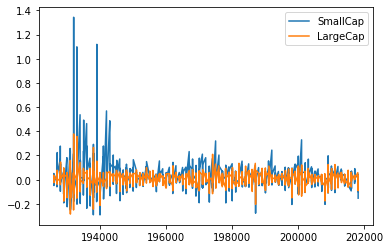

In [1]:
import pandas as pd

me_m = pd.read_csv("data/Portfolios_Formed_on_ME_monthly_EW.csv",
                   header=0, index_col=0, parse_dates=True, na_values=-99.99)
rets = me_m[['Lo 10', 'Hi 10']]
rets.columns = ['SmallCap', 'LargeCap']
rets = rets/100
rets.plot.line()

## 시계열 인덱스 날짜처리

앞서 `read_csv()` 메서드를 통해 `parse_dates`를 요청했습니다. 

단순히 인덱스만을 사용해서도 같은 결과를 얻을 수 있는지 확인해보겠습니다.

In [2]:
rets.index

Int64Index([192607, 192608, 192609, 192610, 192611, 192612, 192701, 192702,
            192703, 192704,
            ...
            201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810,
            201811, 201812],
           dtype='int64', length=1110)

`dtype`은 현재 `int64`로 단순히 숫자입니다. 아직 인덱스가 날짜/시간 인덱스로 변환되지 않았으므로 수동으로 이를 변환해보겠습니다. 시계열을 강제로 적용하는 가장 간단한 방법은 인덱스 데이터를 다음과 같이 `datetime` 유형으로 다시 재포맷하는 것입니다.

In [3]:
rets.index = pd.to_datetime(rets.index, format="%Y%m")
rets.index

DatetimeIndex(['1926-07-01', '1926-08-01', '1926-09-01', '1926-10-01',
               '1926-11-01', '1926-12-01', '1927-01-01', '1927-02-01',
               '1927-03-01', '1927-04-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', length=1110, freq=None)

이제 데이터프레임에 날짜/시간 인덱스가 있으므로 전체 데이터프레임을 매우 편리하게 시계열로 처리할 수 있습니다. 예를 들어, 우리는 다음과 같이 간단하게 2008년의 수익률만 추출할 수 있습니다.

In [4]:
rets["2008"]

,SmallCap,LargeCap
2008-01-01,-0.0436,-0.0490
2008-02-01,-0.0203,-0.0250
2008-03-01,-0.0440,-0.0122
2008-04-01,0.0027,0.0492
2008-05-01,0.0286,0.0161
2008-06-01,-0.0816,-0.1015
2008-07-01,-0.0079,-0.0140
2008-08-01,0.0110,0.0087
2008-09-01,-0.1274,-0.1155
2008-10-01,-0.2041,-0.1763


우리는 `to_period` 메소드를 사용하여 단순히 연과 월로 구성된 인덱스로 다시 재구성할 수 있습니다. 우리는 추후 실습 과정을 통해 시계열과 관련된 판다스 기능의 몇 가지 더 많은 예시들을 살펴볼 것입니다.

In [5]:
rets.index = rets.index.to_period('M')
rets.head()

,SmallCap,LargeCap
1926-07,-0.0145,0.0329
1926-08,0.0512,0.0370
1926-09,0.0093,0.0067
1926-10,-0.0484,-0.0243
1926-11,-0.0078,0.0270


In [6]:
rets.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1110 entries, 1926-07 to 2018-12
Freq: M
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SmallCap  1110 non-null   float64
 1   LargeCap  1110 non-null   float64
dtypes: float64(2)
memory usage: 26.0 KB


In [7]:
rets.describe()

,SmallCap,LargeCap
count,1110.000000,1110.000000
mean,0.017598,0.008870
std,0.106288,0.053900
min,-0.291400,-0.284300
25%,-0.027350,-0.017025
50%,0.010450,0.011400
75%,0.049950,0.037650
max,1.342900,0.377900


## 낙폭 계산하기 (Computing Drawdowns)

낙폭을 계산하기 위해서는 다음과 같은 과정을 거쳐야 합니다.

1. 수익률로 된 시계열 데이터를 명목적인 부의 크기를 나타내는 자산 지수(Wealth Index) 시계열 데이터로 변환
2. 이전 고점들을 트래킹하는 시계열 데이터 계산
3. 이전 고점과 현재 값의 차이로 낙폭을 계산

우선 대형주 포트폴리오에 대해 이 작업을 수행해보겠습니다.

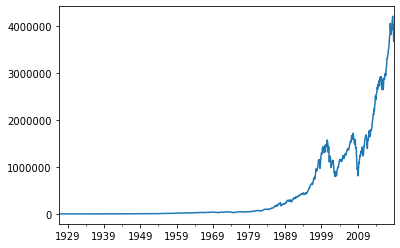

In [8]:
wealth_index = 1000*(1+rets["LargeCap"]).cumprod()
wealth_index.plot()

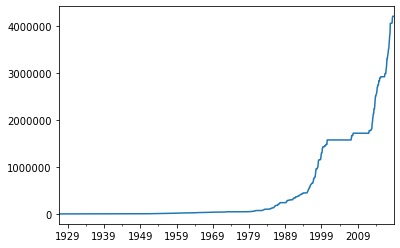

In [9]:
previous_peaks = wealth_index.cummax()
previous_peaks.plot()

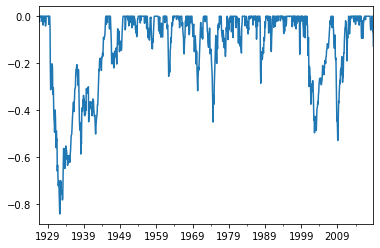

In [10]:
drawdown = (wealth_index - previous_peaks)/previous_peaks
drawdown.plot()

In [11]:
drawdown.min()

-0.8400375277943123

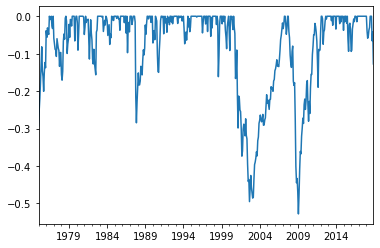

In [12]:
drawdown["1975":].plot()

In [13]:
drawdown["1975":].min()

-0.5280945042309304

# 낙폭 계산 함수 만들기 (Creating a Drawdown Function)

Redoing this analysis for SmallCap would be tedious, since we would need to re-enter all these commands at the prompt. Instead, let's create our first function that will form the first tool in our financial toolkit.

소형주 포트폴리오에 대해 이 과정을 처음부터 다시 실행하는 것은 당연히 매우 지루한 일입니다. 프롬프트에서 지금까지의 모든 명령을 다시 입력해야 하기 때문입니다. 그렇기 때문에 우리는 동일한 코드를 한 번 더 입력하는 대신 자체 제작할 도구상자의 첫 번째 함수를 만들어 보겠습니다.

이 함수는 수익률의 시계열 데이터를 입력변수로 받으며, 자산 지수와 이전 최고점 및 낙폭을 포함하는 데이터프레임을 반환합니다.

* 입력변수(Parameters): (`pd.Series`) 수익률
* 반환(Returns): (`pd.DataFrame`) 자산 지수, 이전 고점, 낙폭

In [14]:
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

drawdown(rets["LargeCap"]).head()

,Wealth,Previous Peak,Drawdown
1926-07,1032.900000,1032.900000,0.0000
1926-08,1071.117300,1071.117300,0.0000
1926-09,1078.293786,1078.293786,0.0000
1926-10,1052.091247,1078.293786,-0.0243
1926-11,1080.497711,1080.497711,0.0000


In [15]:
drawdown(rets["LargeCap"]).min()

Wealth            405.769102
Previous Peak    1032.900000
Drawdown           -0.840038
dtype: float64

In [16]:
drawdown(rets["SmallCap"]).min()

Wealth           491.240323
Previous Peak    985.500000
Drawdown          -0.833001
dtype: float64

In [17]:
drawdown(rets["LargeCap"])["Drawdown"].idxmin()

Period('1932-05', 'M')

In [18]:
drawdown(rets["SmallCap"])["Drawdown"].idxmin()

Period('1932-05', 'M')

In [19]:
drawdown(rets["LargeCap"]["1975":])["Drawdown"].idxmin()

Period('2009-02', 'M')

In [20]:
drawdown(rets["SmallCap"]["1975":])["Drawdown"].idxmin()

Period('2009-02', 'M')

In [21]:
drawdown(rets["SmallCap"]["1975":])["Drawdown"].min()

-0.6312068077252386